<a href="https://colab.research.google.com/github/liz0904/ai_titanic/blob/main/titanic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#구글 드라이브 마운트
from google.colab import drive
drive.mount('/gdrive/')

Mounted at /gdrive/


In [7]:
#<데이터 로딩>

#라이브러리 설정
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#데이콘 사이트에서 다운로드한 csv 파일 읽어오기
drive_path="/gdrive/MyDrive/"
train=pd.read_csv(drive_path+"titanic/train.csv") #판다스 read_csv 함수를 사용해 csv 파일을 읽고 데이터 프레임으로 변환
test=pd.read_csv(drive_path+"titanic/test.csv")
submission=pd.read_csv(drive_path+"titanic/sample_submission.csv")  #제출 파일 양식
print(train.shape, test.shape, submission.shape)  #몇행 몇열인지 확인

(891, 12) (418, 11) (418, 2)


In [11]:
#train 데이터 프레임 내용 확인-생존여부(생존 1, 사망 0)
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [12]:
#test 데이터프레임 내용 확인- 목표변수에 대한 데이터 없음(테스트 데이터라서)
test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [13]:
#submission 제출 파일 양식 확인
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [15]:
#train 데이터프레임 개요 정보-891보다 작은 개수의 non-null 데이터가 있는데, 부족한 개수만큼 missing value 존재
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [17]:
#train 데이터프레임 통계 정보
train.describe(include='all') #all-숫자형이 아닌 문자열 등에 대한 정보를 포함해 show

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Buss, Miss. Kate",male,NaN,NaN,NaN,CA. 2343,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


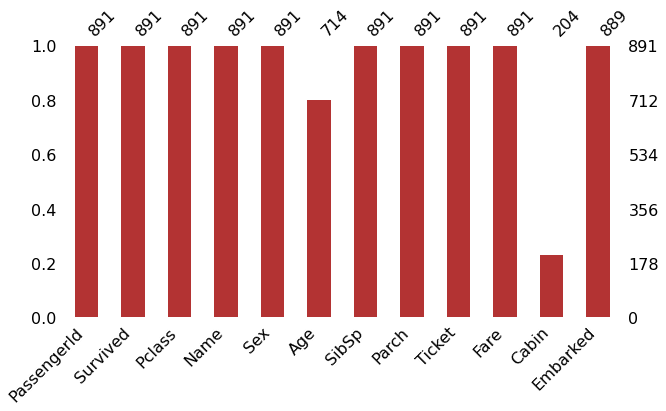

In [22]:
#결측값 분포-missingno 라이브러리 사용
import missingno as msno
msno.bar(train, figsize=(10,5), color=(0.7, 0.2, 0.2))
plt.show()  #Age, Cabin, Embarked 열에 결측값 존재

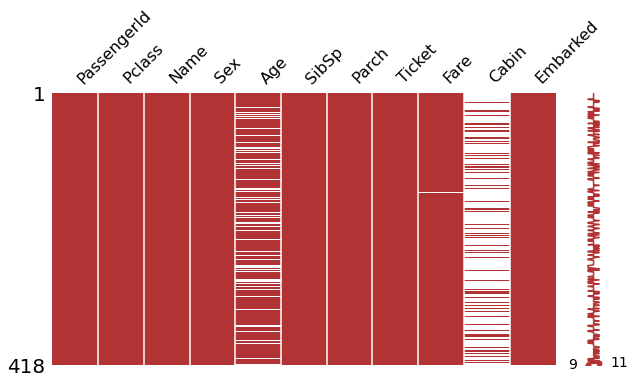

In [23]:
#matrix 함수: 데이터프레미의 어느위치에 결측값이 있는지 확인
msno.matrix(test, figsize=(10,5), color=(0.7, 0.2, 0.2))
plt.show()

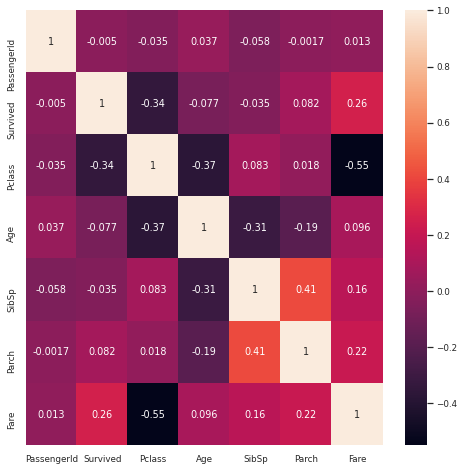

In [26]:
#상관 관계 분석
#숫자형 변수 간의 상관관계를 계산하여 히트맵 그리기
plt.figure(figsize=(8,8))
sns.set(font_scale=0.8)
sns.heatmap(train.corr(), annot=True, cbar=True); #corr 함수: 숫자형 데이터로 구성된 열에 대해서만 상관계수를 계산
plt.show()  #Survived(목표변수)열과 상관관계가 높은 피처는 Pclass와 Fare, 또 Pclass와 Rase끼리의 상관계수(-0.55)도 높음

In [28]:
#데이터 결합-타이타닉 전체 데이터셋 준비
train['TrainSplit']='Train'
test['TrainSplit']='Test'
data=pd.concat([train, test], axis=0) #concat 함수로 데이터프레임(train, test)을 위아래 방향(axis=0)으로 연결
print(data.shape)

(1309, 13)


In [30]:
#데이터 전처리
#숫자형 피처 추출
data_num=data.loc[:,['Pclass','Age','SibSp','Parch', 'Fare', 'Survived']]

#결측값 대체-fillna 함수 사용
data_num['Age']=data_num['Age'].fillna(data_num['Age'].mean())    #Age열의 결측값은 평균값(mean)으로 대체
data_num['Fare']=data_num['Fare'].fillna(data_num['Fare'].mean()) #Fare열의 결측값은 가장 많은 빈도수(최빈값)으로 대체

#학습용 데이터와 예측 대상인 테스트 데이터 구분
selected_features=['Pclass', 'Age','SibSp', 'Parch', 'Fare']
x_train=data_num.loc[data['TrainSplit']=='Train', selected_features]
y_train=data_num.loc[data['TrainSplit']=='Train', 'Survived']

x_test=data_num.loc[data['TrainSplit']=='Test', selected_features]

print("Train 데이터셋 크기:", x_train.shape, y_train.shape)
print("Test 데이터셋 크기", x_test.shape)

Train 데이터셋 크기: (891, 5) (891,)
Test 데이터셋 크기 (418, 5)


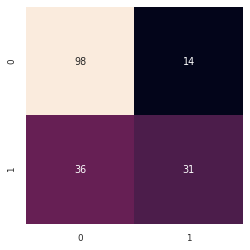

In [33]:
#모델 학습 및 검증-로지스틱 회귀 분류 모델
#훈련 - 검증 데이터 분할(y_val_pred:검증 데이터에 대한 예측값, y_val: 실제값)
#학습데이터 x_train, y_train을 훈련데이터 80%, 검증데이터 20%으로 분할
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val=train_test_split(x_train, y_train, test_size=0.2, shuffle=True, random_state=20)

#로지스틱 회귀 모델
from sklearn.linear_model import LogisticRegression
lr_model=LogisticRegression()
lr_model.fit(x_tr, y_tr)
y_val_pred=lr_model.predict(x_val)

#Confusion Matrix-혼동 행력 계산 및 그래프로 표시
# *혼동 행렬: 모형의 예측값과 실제값을 각각 축으로 하는 2X2 매트릭스로 표현한 것(정밀도, 재현율, F1 지표 산출 가능)
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, cbar=False, square=True)
plt.show()
